In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

## Importanción de datos

In [3]:
! pip install papermill -q
! papermill --version

In [4]:
months = ["2022-5","2022-4","2022-3","2022-2","2022-1","2021-12","2021-11"]
archivo_final = "datos-completos-31-5.csv"

In [5]:
! mkdir -p 'import-result'

In [6]:
for month in months:
    ! papermill 'importar-mes.ipynb' 'import-result/{month}.ipynb' -p mes_datos {month} -p archivo_final {archivo_final} 


In [6]:
! ls

2021-11.csv  2022-4.csv			 datos-completos-31-5.csv
2021-12.csv  2022-5.csv			 importar-mes.ipynb
2022-1.csv   ComprasChile2021-2022.html  import-result
2022-2.csv   ComprasChile.html		 wget-log
2022-3.csv   datasets			 work


In [7]:
df_original_corregido = spark.read.format("csv").options(header=True, delimiter=';',encoding="ISO-8859-1").csv(archivo_final)

In [8]:
df_original_corregido.show(10,vertical=True)

-RECORD 0------------------------------------------
 ID                         | 34790455             
 Codigo                     | 2403-1556-SE17       
 Link                       | http://www.mercad... 
 Nombre                     | TD Mejoramiento c... 
 Descripcion/Obervaciones   | DECRETO DE ADJUDI... 
 Tipo                       | SE                   
 ProcedenciaOC              | licitación públic... 
 EsTratoDirecto             | Si                   
 EsCompraAgil               | No                   
 CodigoTipo                 | 8                    
 CodigoAbreviadoTipoOC      | SE                   
 DescripcionTipoOC          | Sin emisión autom... 
 codigoEstado               | 4                    
 Estado                     | Enviada a proveedor  
 codigoEstadoProveedor      | 1                    
 EstadoProveedor            | Nueva orden de co... 
 FechaCreacion              | 2017-09-27           
 FechaEnvio                 | 2022-05-23           
 FechaSolici

## Ingeniería de Atributos

### Columnas Relevantes
Eliminamos las columnas que no sean relevanes para nuestro analisis, dejando solo las que sí podemos llegar a utilizar 

In [9]:
df_original = df_original_corregido

In [10]:
df_original.columns

['ID',
 'Codigo',
 'Link',
 'Nombre',
 'Descripcion/Obervaciones',
 'Tipo',
 'ProcedenciaOC',
 'EsTratoDirecto',
 'EsCompraAgil',
 'CodigoTipo',
 'CodigoAbreviadoTipoOC',
 'DescripcionTipoOC',
 'codigoEstado',
 'Estado',
 'codigoEstadoProveedor',
 'EstadoProveedor',
 'FechaCreacion',
 'FechaEnvio',
 'FechaSolicitudCancelacion',
 'fechaUltimaModificacion',
 'FechaAceptacion',
 'FechaCancelacion',
 'tieneItems',
 'PromedioCalificacion',
 'CantidadEvaluacion',
 'MontoTotalOC',
 'TipoMonedaOC',
 'MontoTotalOC_PesosChilenos',
 'Impuestos',
 'TipoImpuesto',
 'Descuentos',
 'Cargos',
 'TotalNetoOC',
 'CodigoUnidadCompra',
 'RutUnidadCompra',
 'UnidadCompra',
 'CodigoOrganismoPublico',
 'OrganismoPublico',
 'sector',
 'ActividadComprador',
 'CiudadUnidadCompra',
 'RegionUnidadCompra',
 'PaisUnidadCompra',
 'CodigoSucursal',
 'RutSucursal',
 'Sucursal',
 'CodigoProveedor',
 'NombreProveedor',
 'ActividadProveedor',
 'ComunaProveedor',
 'RegionProveedor',
 'PaisProveedor',
 'Financiamiento',
 'P

In [11]:
df_columnas_relevantes = df_original[
    ['Estado',
 'FechaCreacion',
 'FechaAceptacion',
 'MontoTotalOC_PesosChilenos',
 'OrganismoPublico',
 'sector',
 'CiudadUnidadCompra',
 'RegionUnidadCompra',
 'PaisProveedor',
 'IDItem',
 'RubroN1',
 'RubroN2',
 'RubroN3',
 'cantidad',
 'UnidadMedida']
]

In [12]:
df_columnas_relevantes.show(15,vertical=True)

-RECORD 0------------------------------------------
 Estado                     | Enviada a proveedor  
 FechaCreacion              | 2017-09-27           
 FechaAceptacion            | NA                   
 MontoTotalOC_PesosChilenos | 1080919609,14        
 OrganismoPublico           | I MUNICIPALIDAD D... 
 sector                     | Municipalidades      
 CiudadUnidadCompra         | Peñalolén            
 RegionUnidadCompra         | Región Metropolit... 
 PaisProveedor              | Chile                
 IDItem                     | 89939120             
 RubroN1                    | Servicios de cons... 
 RubroN2                    | Construcción de e... 
 RubroN3                    | Construcción de o... 
 cantidad                   | 1                    
 UnidadMedida               | Unidad               
-RECORD 1------------------------------------------
 Estado                     | Aceptada             
 FechaCreacion              | 2018-11-13           
 FechaAcepta

Cantidad de datos al elegir las columnas relevantes a analizar:

In [13]:
df_columnas_relevantes.count()

2587212

#### Eliminar filas que no cuentas con un Estado válido. Deberían ser solo 5 posibles valores

In [14]:
df_columnas_relevantes.select("Estado").distinct().show(vertical=True)

-RECORD 0----------------------
 Estado | Compra Ágil          
-RECORD 1----------------------
 Estado | Sin emisión autom... 
-RECORD 2----------------------
 Estado | Convenio Marco       
-RECORD 3----------------------
 Estado | 8                    
-RECORD 4----------------------
 Estado | Estado               
-RECORD 5----------------------
 Estado | 5                    
-RECORD 6----------------------
 Estado |  Llave               
-RECORD 7----------------------
 Estado | 6                    
-RECORD 8----------------------
 Estado | Costo de evaluaci... 
-RECORD 9----------------------
 Estado | CM                   
-RECORD 10---------------------
 Estado | Cancelacion solic... 
-RECORD 11---------------------
 Estado | En proceso           
-RECORD 12---------------------
 Estado | AG                   
-RECORD 13---------------------
 Estado | Adquisición igual... 
-RECORD 14---------------------
 Estado | SE                   
-RECORD 15---------------------
 Estado 

In [16]:
estados_validos = ["Aceptada", "En proceso","Cancelacion solicitada", "Enviada a proveedor", "Recepcion Conforme"] 

In [17]:
df_estados_validos =df_columnas_relevantes.filter(df_columnas_relevantes.Estado.isin(estados_validos))
df_estados_validos.select("Estado").distinct().show(vertical=True)

-RECORD 0----------------------
 Estado | Cancelacion solic... 
-RECORD 1----------------------
 Estado | En proceso           
-RECORD 2----------------------
 Estado | Recepcion Conforme   
-RECORD 3----------------------
 Estado | Enviada a proveedor  
-RECORD 4----------------------
 Estado | Aceptada             



### Analisis de atributos


In [18]:
df = df_estados_validos

In [19]:
df.printSchema()

root
 |-- Estado: string (nullable = true)
 |-- FechaCreacion: string (nullable = true)
 |-- FechaAceptacion: string (nullable = true)
 |-- MontoTotalOC_PesosChilenos: string (nullable = true)
 |-- OrganismoPublico: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- CiudadUnidadCompra: string (nullable = true)
 |-- RegionUnidadCompra: string (nullable = true)
 |-- PaisProveedor: string (nullable = true)
 |-- IDItem: string (nullable = true)
 |-- RubroN1: string (nullable = true)
 |-- RubroN2: string (nullable = true)
 |-- RubroN3: string (nullable = true)
 |-- cantidad: string (nullable = true)
 |-- UnidadMedida: string (nullable = true)



In [20]:
from pyspark.sql.functions import isnan, when, count, col

In [21]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0----------------------------
 Estado                     | 0      
 FechaCreacion              | 0      
 FechaAceptacion            | 0      
 MontoTotalOC_PesosChilenos | 0      
 OrganismoPublico           | 0      
 sector                     | 0      
 CiudadUnidadCompra         | 336    
 RegionUnidadCompra         | 0      
 PaisProveedor              | 201426 
 IDItem                     | 0      
 RubroN1                    | 0      
 RubroN2                    | 0      
 RubroN3                    | 0      
 cantidad                   | 45     
 UnidadMedida               | 11     



Convertimos las fechas a formato fecha

In [22]:
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType, IntegerType, DateType

In [23]:
# Convert the date column to a datetype with format year-month-day
from pyspark.sql.functions import to_date
df = df.withColumn('FechaCreacion', to_date(col('FechaCreacion'), 'yyyy-MM-dd'))
df = df.withColumn('FechaAceptacion', to_date(col('FechaAceptacion'), 'yyyy-MM-dd'))

In [24]:
df['FechaCreacion','FechaAceptacion'].printSchema()

root
 |-- FechaCreacion: date (nullable = true)
 |-- FechaAceptacion: date (nullable = true)



Convertimos el formato de datos númericos con coma, a datos númericos con puntos.

In [25]:
from pyspark.sql.functions import regexp_replace
df = df.withColumn('MontoTotalOC_PesosChilenos', regexp_replace('MontoTotalOC_PesosChilenos', ',', '.'))
df = df.withColumn('MontoTotalOC_PesosChilenos', df['MontoTotalOC_PesosChilenos'].cast(DoubleType()))

In [26]:
df = df.filter(df.cantidad.rlike("[0-9,]"))
df = df.withColumn('cantidad', regexp_replace('cantidad', ',', '.'))
df = df.withColumn('cantidad', col('cantidad').cast(DoubleType())) 

Convertimos los valores númericos a sus repectivos tipos

In [27]:
df = df.withColumn('IDItem', col('IDItem').cast(IntegerType()))

In [28]:
df['MontoTotalOC_PesosChilenos','IDItem', 'cantidad'].printSchema()

root
 |-- MontoTotalOC_PesosChilenos: double (nullable = true)
 |-- IDItem: integer (nullable = true)
 |-- cantidad: double (nullable = true)



In [29]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0----------------------------
 Estado                     | 0      
 FechaCreacion              | 0      
 FechaAceptacion            | 153161 
 MontoTotalOC_PesosChilenos | 0      
 OrganismoPublico           | 0      
 sector                     | 0      
 CiudadUnidadCompra         | 336    
 RegionUnidadCompra         | 0      
 PaisProveedor              | 201375 
 IDItem                     | 0      
 RubroN1                    | 0      
 RubroN2                    | 0      
 RubroN3                    | 0      
 cantidad                   | 283    
 UnidadMedida               | 9      



La explicación de por qué la columna FechaAceptación tiene nulos es porque no todas las compras fueron aceptadas, mientras que todas las compras fueron creadas (sino no estarían en el dataset)

In [30]:
## Filter the rows that has FechaAceptacion null
df = df.filter(df.FechaAceptacion.isNotNull())

In [31]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0----------------------------
 Estado                     | 0      
 FechaCreacion              | 0      
 FechaAceptacion            | 0      
 MontoTotalOC_PesosChilenos | 0      
 OrganismoPublico           | 0      
 sector                     | 0      
 CiudadUnidadCompra         | 332    
 RegionUnidadCompra         | 0      
 PaisProveedor              | 189421 
 IDItem                     | 0      
 RubroN1                    | 0      
 RubroN2                    | 0      
 RubroN3                    | 0      
 cantidad                   | 272    
 UnidadMedida               | 9      



In [32]:
df.show(15,vertical=True)

-RECORD 0------------------------------------------
 Estado                     | Aceptada             
 FechaCreacion              | 2018-11-13           
 FechaAceptacion            | 2022-05-26           
 MontoTotalOC_PesosChilenos | 2.83880017316E9      
 OrganismoPublico           | SERVICIO DE VIVIE... 
 sector                     | Obras Públicas       
 CiudadUnidadCompra         | Talca                
 RegionUnidadCompra         | Región del Maule     
 PaisProveedor              | Chile                
 IDItem                     | 99540855             
 RubroN1                    | Servicios de cons... 
 RubroN2                    | Construcción de e... 
 RubroN3                    | Construcción de o... 
 cantidad                   | 1.0                  
 UnidadMedida               | Global               
-RECORD 1------------------------------------------
 Estado                     | Aceptada             
 FechaCreacion              | 2018-11-13           
 FechaAcepta

In [33]:
df.printSchema()

root
 |-- Estado: string (nullable = true)
 |-- FechaCreacion: date (nullable = true)
 |-- FechaAceptacion: date (nullable = true)
 |-- MontoTotalOC_PesosChilenos: double (nullable = true)
 |-- OrganismoPublico: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- CiudadUnidadCompra: string (nullable = true)
 |-- RegionUnidadCompra: string (nullable = true)
 |-- PaisProveedor: string (nullable = true)
 |-- IDItem: integer (nullable = true)
 |-- RubroN1: string (nullable = true)
 |-- RubroN2: string (nullable = true)
 |-- RubroN3: string (nullable = true)
 |-- cantidad: double (nullable = true)
 |-- UnidadMedida: string (nullable = true)



In [34]:
df.count()

2430357

De las originales 2587212, eliminamos 156855 líneas del data set, un 6%. 

### Convertimos a Pandas

Primero vamos a hacer un 'sample' de nuestro datos ya que Pandas no soporta los 2 millones de datos que tenemos. Por lo tanto, los resultados del PandaReport son una representación del dataset original.

In [35]:
df_sample = df.sample(False, 0.3, seed = 1)

In [36]:
import sys
import seaborn as sns 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [37]:
dfp = df_sample.toPandas() 

In [38]:
dfp.head(10) 

,Estado,FechaCreacion,FechaAceptacion,MontoTotalOC_PesosChilenos,OrganismoPublico,sector,CiudadUnidadCompra,RegionUnidadCompra,PaisProveedor,IDItem,RubroN1,RubroN2,RubroN3,cantidad,UnidadMedida
0,Aceptada,2018-11-13,2022-05-26,2.838800e+09,SERVICIO DE VIVIENDA Y URBANIZACION VII REGION,Obras Públicas,Talca,Región del Maule,Chile,99540855,Servicios de construcción y mantenimiento,Construcción de edificios en general,Construcción de obras civiles y infraestructuras,1.0,Global
1,Aceptada,2018-11-13,2022-05-26,2.838800e+09,SERVICIO DE VIVIENDA Y URBANIZACION VII REGION,Obras Públicas,Talca,Región del Maule,Chile,99540857,Servicios de construcción y mantenimiento,Construcción de edificios en general,Construcción de obras civiles y infraestructuras,1.0,Global
2,Aceptada,2019-07-25,2022-05-17,1.190000e+00,I MUNICIPALIDAD DE QUINTERO,Municipalidades,Quintero,Región de Valparaíso,Chile,105227828,"Servicios financieros, pensiones y seguros",Banca e inversiones,"Servicios de transferencia de fondos, compensa...",1.0,Unidad
3,Recepcion Conforme,2020-08-27,2022-05-09,4.293901e+05,SERVICIO DE SALUD HOSPITAL DE RENGO,Salud,Rengo,Región del Libertador General Bernardo O´Higgins,Chile,112484904,Equipamiento y suministros médicos,Productos quirúrgicos,"Juegos de instrumentos, sistemas y bandejas qu...",1.0,Global
4,Recepcion Conforme,2021-01-14,2022-05-09,6.188000e+04,SERVICIO DE SALUD COQUIMBO HOSPITAL DR. HUMBER...,Salud,Illapel,Región de Coquimbo,NA,114790898,Equipamiento y suministros médicos,Equipos y suministros odontológicos,Suministros y equipos de odontología cosmética,13.0,Unidad
5,Recepcion Conforme,2021-04-15,2022-05-05,4.239146e+07,I MUNICIPALIDAD DE CODEGUA,Municipalidades,Codegua,Región del Libertador General Bernardo O´Higgins,NA,116098748,Servicios de construcción y mantenimiento,Construcción de edificios en general,Construcción de obras civiles y infraestructuras,1.0,Unidad
6,Aceptada,2021-05-14,2022-05-30,7.683234e+06,HOSPITAL DR GUSTAVO FRICKE DE VINA DEL MAR,Salud,Viña del Mar,Región de Valparaíso,Chile,116557752,Equipamiento y suministros médicos,"Productos medicinales para deportes, prostétic...","Dispositivos, accesorios y suministros protésicos",1.0,Unidad
7,Aceptada,2021-05-19,2022-05-19,1.670394e+10,I MUNICIPALIDAD DE QUILICURA,Municipalidades,Quilicura,Región Metropolitana de Santiago,Chile,116614019,Servicios de limpieza industrial,Eliminación y tratamiento de desechos,Recolección y eliminación de desechos,72.0,Mes
8,Recepcion Conforme,2021-07-08,2022-05-06,1.523200e+07,HOSPITAL COMPLEJO ASISTENCIAL PADRE LAS CASAS,Otros,Padre Las Casas,Región de la Araucanía,Chile,117339388,Medicamentos y productos farmacéuticos,Medicamentos para el sistema nervioso central,"Fármacos anestésicos, complementos relacionado...",400.0,Frasco Ampolla
9,Aceptada,2021-07-29,2022-05-20,1.216418e+08,MINISTERIO DE OBRAS PUBLICAS DIREC CION GRAL D...,Obras Públicas,Talca,Región del Maule,NA,117627372,"Servicios de defensa nacional, orden público y...",Orden público y seguridad,Servicios de seguridad y policiales,1.0,Unidad


In [39]:
df_category = dfp
print(df_category.columns)

Index(['Estado', 'FechaCreacion', 'FechaAceptacion',
       'MontoTotalOC_PesosChilenos', 'OrganismoPublico', 'sector',
       'CiudadUnidadCompra', 'RegionUnidadCompra', 'PaisProveedor', 'IDItem',
       'RubroN1', 'RubroN2', 'RubroN3', 'cantidad', 'UnidadMedida'],
      dtype='object')


In [40]:
for col in df_category.columns:
    df_category[col] = df_category[col].astype('category')
    df_category[col] = df_category[col].cat.codes

In [41]:
dfpandas = df_category

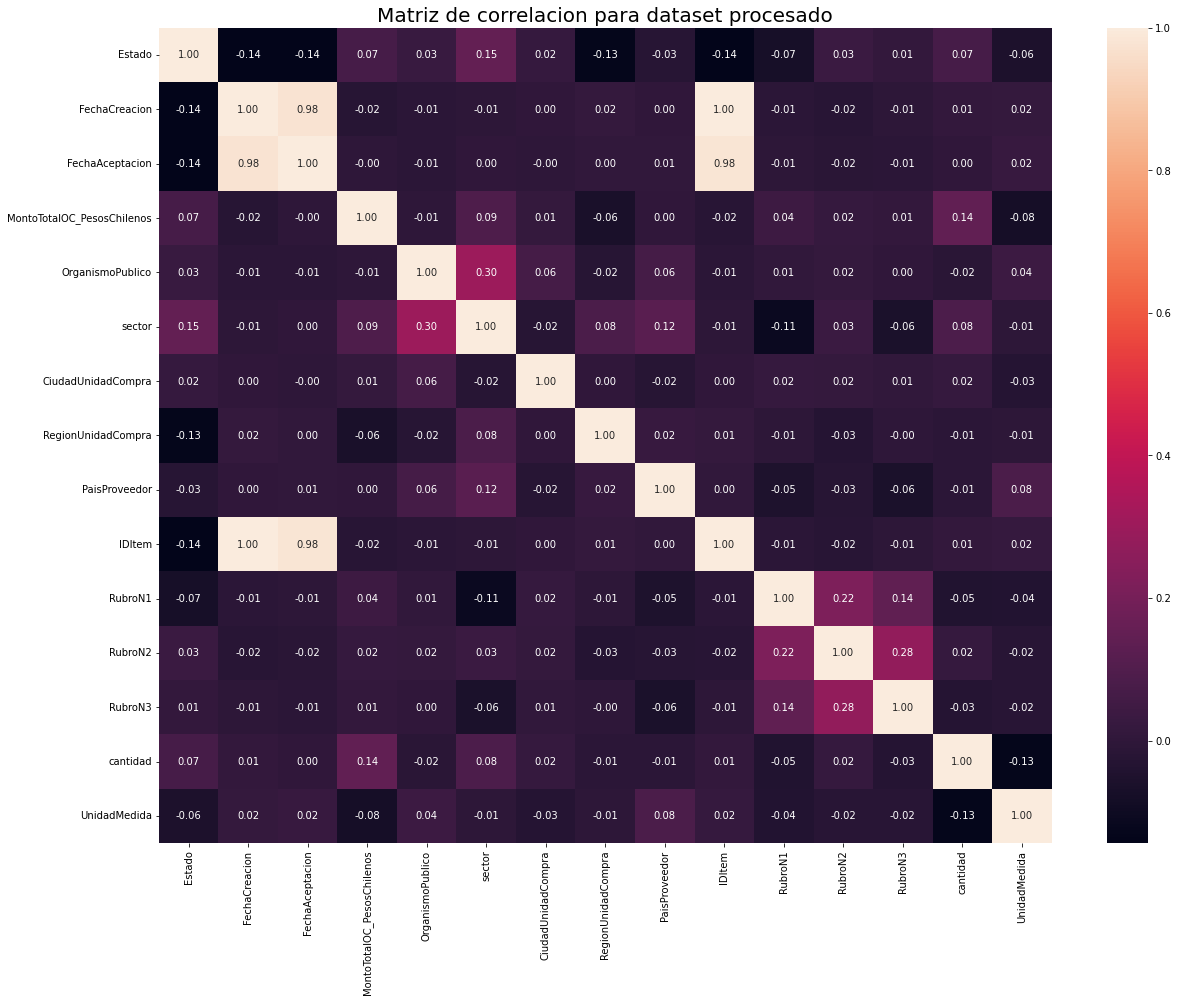

In [42]:
# Correlation matrix
corr = dfpandas.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr,  annot = True, fmt = '.2f')
plt.title('Matriz de correlacion para dataset procesado', fontsize = 20)
plt.show()

In [119]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from ipywidgets import FloatProgress
import matplotlib.pyplot as plt
%matplotlib inline

profile = ProfileReport(dfpandas, title="Compras del estado Chileno", minimal = True)

In [120]:
profile.to_file("ComprasChile2021-2022.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Análisis de DataSets en base a preguntas objetivo

In [122]:
from pyspark.sql.functions import *

In [139]:
# # UDF to process the currancy column

conversionRate = 800 # How many chilean pesos = 1 dollar, estimated 
def toCurrancy (pesos):
    
    dollars = pesos/conversionRate
    finalDollars = "US$ {:,.0f}".format(dollars)
    return finalDollars
    
udfToCurrancy = udf(lambda x: toCurrancy(x))

In [140]:
udfToDollars = udf(lambda x: 0 if x is None else x/800)

#### ¿ Cual fue el gasto total del Estado Chileno en los meses analizados? 

Vamos a usar este valor como referencia para las consultas posteriores

In [199]:
df.select(sum(col("MontoTotalOC_PesosChilenos")).alias("Total Gastos")).withColumn('Total Gastos', udfToCurrancy(col('Total Gastos'))).show(truncate=False)

+------------------+
|Total Gastos      |
+------------------+
|US$ 17,935,363,328|
+------------------+



In [219]:
gasto_total = df.select(sum(col("MontoTotalOC_PesosChilenos")).alias("Total Gastos")).withColumn('Total Gastos', (col('Total Gastos')))
gasto_total = gasto_total.collect()[0][0]

In [218]:
gasto_total = float(gasto_total)
gasto_total = gasto_total/7
gasto_usd = toCurrancy(gasto_total)
print(gasto_usd)

US$ 2,562,194,761


Vamos a hacer un histograma de los montos gastados para poder observar la distribución de las compras

In [142]:
df_solo_gastos = df.select(col("MontoTotalOC_PesosChilenos")).alias("Total Gastos")
df_solo_gastos.show()

+--------------------------+
|MontoTotalOC_PesosChilenos|
+--------------------------+
|           2.83880017316E9|
|           2.83880017316E9|
|           2.83880017316E9|
|                      1.19|
|                 893277.07|
|                 402359.23|
|                 429390.08|
|                 882148.19|
|                   61880.0|
|                 690175.01|
|                 2605778.7|
|                 1823270.4|
|             4.239146044E7|
|             1.441194244E7|
|                7683233.81|
|          1.67039367516E10|
|                 5840139.2|
|                  570248.0|
|                  1.1781E7|
|                1.489766E7|
+--------------------------+
only showing top 20 rows



In [143]:
df_solo_gastosPD = df_solo_gastos.toPandas()

In [144]:
df_solo_gastosPD

,MontoTotalOC_PesosChilenos
0,2.838800e+09
1,2.838800e+09
2,2.838800e+09
3,1.190000e+00
4,8.932771e+05
...,...
2430352,3.672483e+05
2430353,4.098360e+05
2430354,3.120382e+05
2430355,1.390630e+05


<AxesSubplot:>

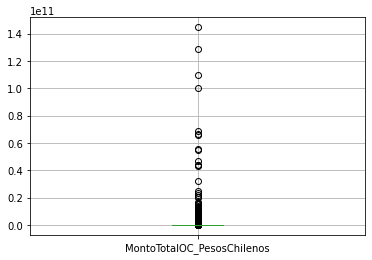

In [145]:
df_solo_gastosPD.boxplot()

Hay varias compras con valores muy altos, por lo tanto (como se ve en el box plot de arriba) por lo tanto representar todos los datos usando un histograma no resultó útil

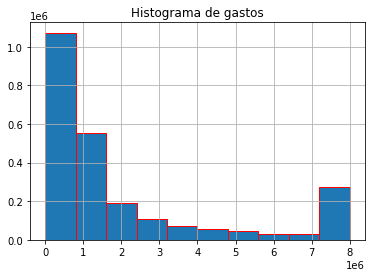

In [146]:
df_solo_gastosPD.clip(800,10000*800).hist(edgecolor='red',column='MontoTotalOC_PesosChilenos')
plt.title('Histograma de gastos')
plt.show()


#### ¿Qué áreas está el Estado chileno invirtiendo más?

In [149]:
# Primero comparamos por sector 
df.groupBy("sector").agg(sum(col("MontoTotalOC_PesosChilenos")).alias("Total Gastos")).orderBy(desc("Total Gastos")).withColumn('Total Gastos', udfToCurrancy(col('Total Gastos'))).show(truncate=False)

+---------------------------+-----------------+
|sector                     |Total Gastos     |
+---------------------------+-----------------+
|Salud                      |US$ 8,907,535,239|
|Municipalidades            |US$ 3,891,131,770|
|Gob. Central, Universidades|US$ 3,240,210,412|
|FFAA                       |US$ 1,322,828,668|
|Obras Públicas             |US$ 354,656,547  |
|Otros                      |US$ 132,662,204  |
|Legislativo y judicial     |US$ 86,338,487   |
+---------------------------+-----------------+



In [150]:
df_sector = df.groupBy("sector").agg(sum(col("MontoTotalOC_PesosChilenos")).alias("Total Gastos")).orderBy(desc("Total Gastos")).withColumn('Total Gastos', udfToDollars(col('Total Gastos')))

df_sector = df_sector.withColumn('Total Gastos', df_sector['Total Gastos'].cast(DoubleType()))
df_sector.printSchema()

root
 |-- sector: string (nullable = true)
 |-- Total Gastos: double (nullable = true)



In [151]:
sector_array = df_sector.select(col("sector")).rdd.map(lambda x: x[0]).collect()
dfp_sector = df_sector.toPandas()

<BarContainer object of 7 artists>

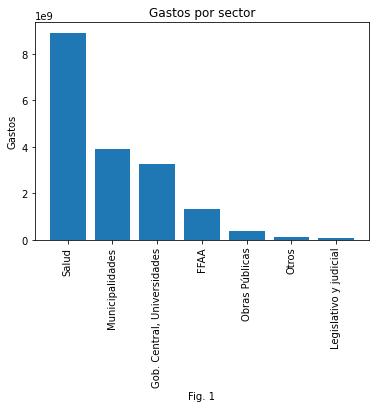

In [260]:
%matplotlib inline
plt.title("Gastos por sector")
plt.xlabel("Sector")
plt.ylabel("Gastos")
plt.xticks(rotation=90, horizontalalignment="center")
plt.rcParams["figure.figsize"] = [25, 15]
plt.xlabel('''Fig. 1''')
plt.bar(sector_array, dfp_sector["Total Gastos"])

Por rubros

In [153]:
df.groupBy("RubroN1").agg(sum(col("MontoTotalOC_PesosChilenos")).alias("Total Gastos")).orderBy(desc("Total Gastos")).withColumn('Total Gastos', udfToCurrancy(col('Total Gastos'))).show(truncate=False)

+-------------------------------------------------------------------------------------------------------+-----------------+
|RubroN1                                                                                                |Total Gastos     |
+-------------------------------------------------------------------------------------------------------+-----------------+
|Equipamiento y suministros médicos                                                                     |US$ 2,854,918,768|
|Equipamiento para laboratorios                                                                         |US$ 2,291,445,398|
|Salud, servicios sanitarios y alimentación                                                             |US$ 1,571,860,421|
|Medicamentos y productos farmacéuticos                                                                 |US$ 1,226,594,416|
|NA                                                                                                     |US$ 1,149,732,290|
|Organiz

#### ¿Cuántos gastos mayores al millón de dólares fueron efectuados entre el  noviembre 2021 y mayo de 2022?

In [154]:
df_gastos = df.select("MontoTotalOC_PesosChilenos","RubroN1","RubroN2","RubroN3","sector").filter(udfToDollars(col("MontoTotalOC_PesosChilenos")) > 1000000.00).orderBy(desc("MontoTotalOC_PesosChilenos")).withColumn('MontoTotalOC_PesosChilenos', udfToCurrancy(col('MontoTotalOC_PesosChilenos')))
df_gastos.show(25,vertical=True, truncate=False)

-RECORD 0-----------------------------------------------------------------------------------------------------------------------------
 MontoTotalOC_PesosChilenos | US$ 180,793,734                                                                                         
 RubroN1                    | Servicios agrícolas, pesqueros, forestales y relacionados con la fauna                                  
 RubroN2                    | Horticultura                                                                                            
 RubroN3                    | Plantas y árboles ornamentales                                                                          
 sector                     | Municipalidades                                                                                         
-RECORD 1-----------------------------------------------------------------------------------------------------------------------------
 MontoTotalOC_PesosChilenos | US$ 160,531,140          

In [155]:
df_gastos.count()

1002

In [156]:
df_sector_millon = df_gastos.groupBy("sector").agg(sum(col("MontoTotalOC_PesosChilenos")).alias("Total Gastos")).orderBy(desc("Total Gastos")).withColumn('Total Gastos', udfToDollars(col('Total Gastos')))

df_sector_millon = df_sector.withColumn('Total Gastos', df_sector['Total Gastos'].cast(DoubleType()))
df_sector_millon.show(truncate=False)

+---------------------------+--------------------+
|sector                     |Total Gastos        |
+---------------------------+--------------------+
|Salud                      |8.907535238941929E9 |
|Municipalidades            |3.8911317698629565E9|
|Gob. Central, Universidades|3.2402104118967853E9|
|FFAA                       |1.3228286684048193E9|
|Obras Públicas             |3.5465654726808715E8|
|Otros                      |1.3266220447560206E8|
|Legislativo y judicial     |8.633848732221097E7 |
+---------------------------+--------------------+



In [269]:
dfp_sector_millon = df_sector_millon.toPandas()
dfp_sector = dfp_sector_millon.groupby(['sector']).sum()

array([<AxesSubplot:>], dtype=object)

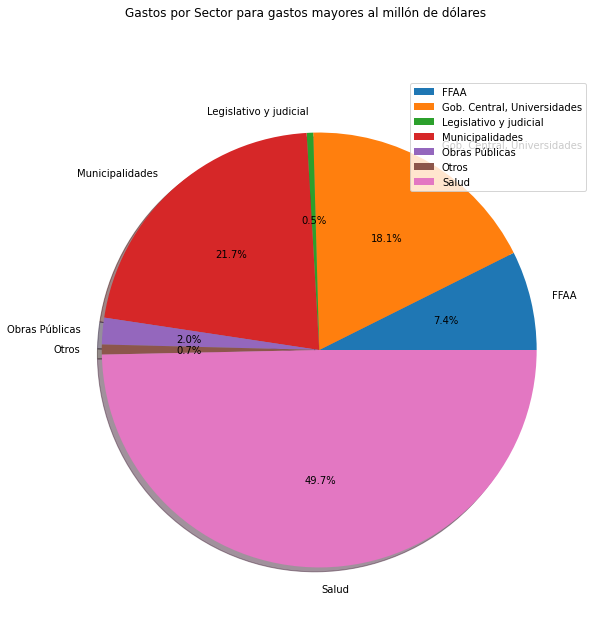

In [300]:
dfp_sector.plot(kind='pie', subplots=True, shadow = True,startangle=0,
figsize=(15,10), autopct='%1.1f%%', title="Gastos por Sector para gastos mayores al millón de dólares", xlabel="Fig. 2", ylabel="")

#### ¿Cuál fue el gasto promedio en general?

In [158]:
df.select(avg(col("MontoTotalOC_PesosChilenos")).alias("Promedio de Gastos")).withColumn('Promedio de Gastos', udfToCurrancy(col('Promedio de Gastos'))).show(truncate=False)

+------------------+
|Promedio de Gastos|
+------------------+
|US$ 7,380         |
+------------------+



#### ¿Cuál fue el gasto promedio de una compra por mes?

In [159]:
df.filter(~col("FechaAceptacion").isNull()).groupBy(month(col("FechaAceptacion")).alias("Mes")).agg(avg(col("MontoTotalOC_PesosChilenos")).alias("Promedio Gastos")).orderBy(desc("Promedio Gastos")).withColumn('Promedio Gastos', udfToCurrancy(col('Promedio Gastos'))).show(truncate=False)

+---+---------------+
|Mes|Promedio Gastos|
+---+---------------+
|4  |US$ 8,887      |
|1  |US$ 7,733      |
|2  |US$ 7,521      |
|12 |US$ 7,510      |
|3  |US$ 7,501      |
|5  |US$ 6,805      |
|11 |US$ 5,913      |
+---+---------------+



In [160]:
df_promedio_mes = df.filter(~col("FechaAceptacion").isNull()).groupBy(month(col("FechaAceptacion")).alias("Mes")).agg(avg(col("MontoTotalOC_PesosChilenos")).alias("Promedio Gastos")).orderBy(desc("Promedio Gastos")).withColumn('Promedio Gastos', udfToDollars(col('Promedio Gastos')))

df_promedio_mes = df_promedio_mes.withColumn('Promedio Gastos', df_promedio_mes['Promedio Gastos'].cast(DoubleType()))
df_promedio_mes.printSchema()

root
 |-- Mes: integer (nullable = true)
 |-- Promedio Gastos: double (nullable = true)



In [161]:
dfp_promedio_mes = df_promedio_mes.toPandas()

<BarContainer object of 7 artists>

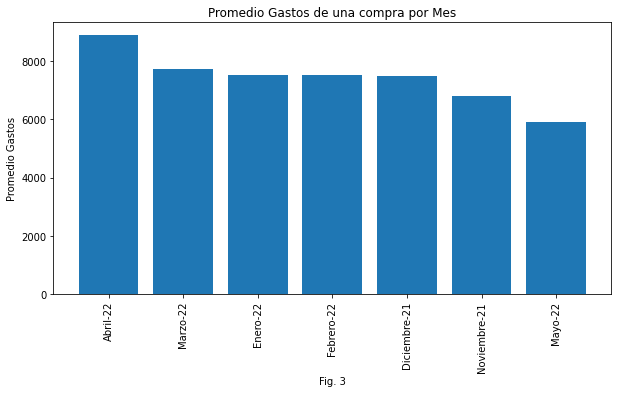

In [287]:
x = ['Abril-22', 'Marzo-22', 'Enero-22', 'Febrero-22', 'Diciembre-21', 'Noviembre-21', 'Mayo-22']
plt.title("Promedio Gastos de una compra por Mes")
plt.xlabel("Mes")
plt.ylabel("Promedio Gastos")
plt.rcParams["figure.figsize"] = [15, 10]
plt.xticks(rotation=90, horizontalalignment="center")
plt.xlabel('''Fig. 3''')
plt.bar(x, dfp_promedio_mes["Promedio Gastos"])

#### ¿Cuál fue la compra más repetido del estado?

In [164]:
df.select(col("IDItem")).groupBy(col("IDItem")).count().orderBy(desc("count")).show(truncate=False)

+---------+-----+
|IDItem   |count|
+---------+-----+
|119302809|3    |
|121391887|2    |
|122239748|2    |
|121369081|2    |
|121369080|2    |
|121369076|2    |
|122239751|2    |
|121391889|2    |
|121124510|2    |
|121408768|2    |
|120160195|2    |
|121391882|2    |
|121667811|2    |
|119221096|2    |
|121369082|2    |
|121391898|2    |
|121391893|2    |
|121922883|2    |
|119221094|2    |
|121361741|2    |
+---------+-----+
only showing top 20 rows



#### ¿En que regiónes se realizáron los mayores gastos?

In [165]:
df.groupBy("RegionUnidadCompra").agg(sum(col("MontoTotalOC_PesosChilenos")).alias("Total Gastos")).orderBy(desc("Total Gastos")).withColumn('Total Gastos', udfToCurrancy(col('Total Gastos'))).show(truncate=False)

+------------------------------------------------+-----------------+
|RegionUnidadCompra                              |Total Gastos     |
+------------------------------------------------+-----------------+
|Región Metropolitana de Santiago                |US$ 8,779,409,333|
|Región del Biobío                               |US$ 1,631,160,104|
|Región de Valparaíso                            |US$ 1,416,731,436|
|Región de los Lagos                             |US$ 896,862,791  |
|Región de la Araucanía                          |US$ 779,696,152  |
|Región del Maule                                |US$ 705,897,333  |
|Región del Libertador General Bernardo O´Higgins|US$ 539,289,846  |
|Región de Coquimbo                              |US$ 456,887,641  |
|Región de Antofagasta                           |US$ 438,320,930  |
|Región de Tarapacá                              |US$ 432,761,085  |
|Región del Ñuble                                |US$ 402,963,466  |
|Región de Los Ríos               

In [166]:
df_region = df.groupBy("RegionUnidadCompra").agg(sum(col("MontoTotalOC_PesosChilenos")).alias("Total Gastos")).orderBy(desc("Total Gastos")).withColumn('Total Gastos', udfToDollars(col('Total Gastos')))

df_region = df_region.withColumn('Total Gastos', df_region['Total Gastos'].cast(DoubleType()))
df_region.printSchema()

root
 |-- RegionUnidadCompra: string (nullable = true)
 |-- Total Gastos: double (nullable = true)



In [167]:
regions_array = df_region.select(col("RegionUnidadCompra")).rdd.map(lambda x: x[0]).collect()
dfp_region = df_region.toPandas()

<BarContainer object of 17 artists>

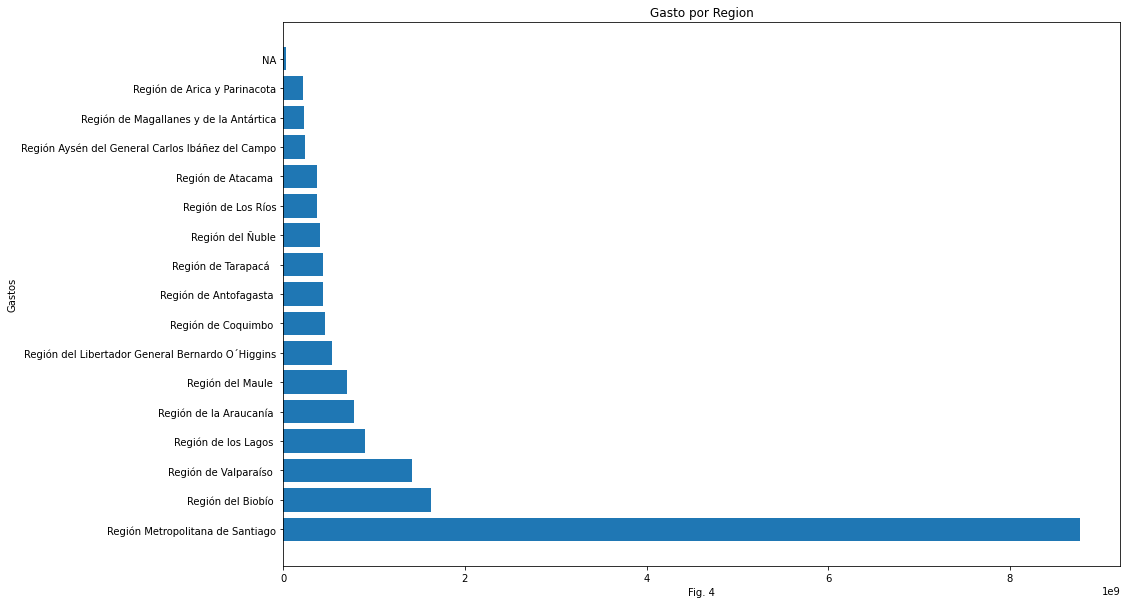

In [288]:
plt.title("Gasto por Region")
plt.xlabel("Region")
plt.ylabel("Gastos")
plt.xlabel('''Fig. 4''')
plt.xticks(rotation=0, horizontalalignment="center")
plt.barh(regions_array, dfp_region["Total Gastos"])

In [169]:
# Para la Region que se relizan los mayores gastos, como se distribuyen por sector?
df.filter(col("RegionUnidadCompra") == regions_array[0]).groupBy("sector").agg(sum(col("MontoTotalOC_PesosChilenos")).alias("Total Gastos")).orderBy(desc("Total Gastos")).withColumn('Total Gastos', udfToCurrancy(col('Total Gastos'))).show(truncate=False)

+---------------------------+-----------------+
|sector                     |Total Gastos     |
+---------------------------+-----------------+
|Salud                      |US$ 4,508,709,246|
|Gob. Central, Universidades|US$ 2,186,967,358|
|Municipalidades            |US$ 1,174,530,086|
|FFAA                       |US$ 747,227,133  |
|Obras Públicas             |US$ 103,754,654  |
|Legislativo y judicial     |US$ 40,181,237   |
|Otros                      |US$ 18,039,619   |
+---------------------------+-----------------+



In [170]:
df_region_metropolitana = df.filter(col("RegionUnidadCompra") == regions_array[0]).groupBy("sector").agg(sum(col("MontoTotalOC_PesosChilenos")).alias("Total Gastos")).orderBy(desc("Total Gastos")).withColumn('Total Gastos', udfToDollars(col('Total Gastos')))
df_region_metropolitana = df_region_metropolitana.withColumn('Total Gastos', df_region_metropolitana['Total Gastos'].cast(DoubleType()))

In [171]:
sectores = df_region_metropolitana.select(col("sector")).rdd.map(lambda x: x[0]).collect()
dfp_region_metropolitana = df_region_metropolitana.toPandas()

array([<AxesSubplot:>], dtype=object)

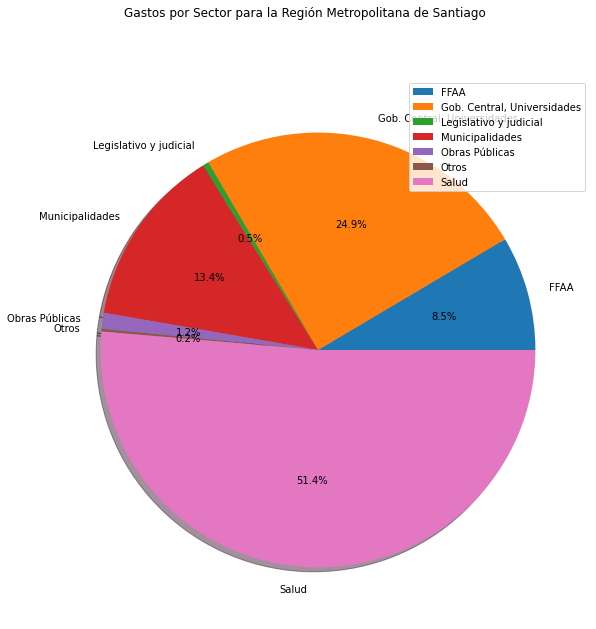

In [299]:
dfp_region_metropolitana.groupby(['sector']).sum().plot(kind='pie', subplots=True, shadow = True,startangle=0,
figsize=(15,10), autopct='%1.1f%%', title="Gastos por Sector para la Región Metropolitana de Santiago",xlabel="Fig. 5", ylabel="", )


array([<AxesSubplot:>], dtype=object)

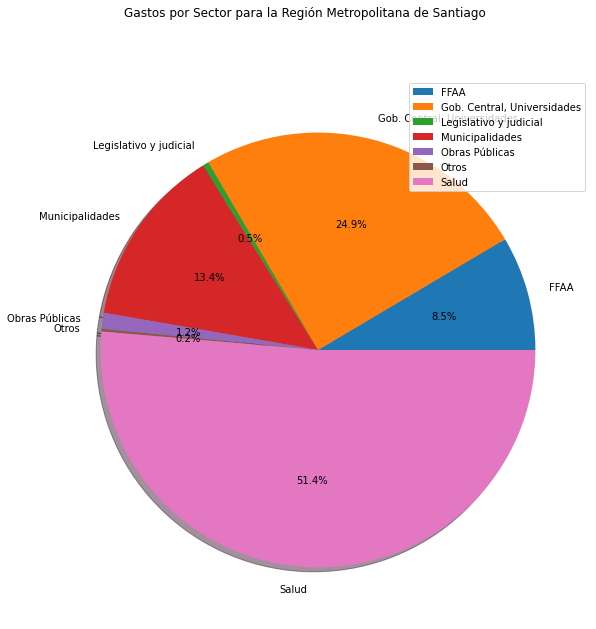

In [297]:

dfp_region_metropolitana.groupby(['sector']).sum().plot(kind='pie', subplots=True, shadow = True,startangle=0,
figsize=(15,10), autopct='%1.1f%%', title="Gastos por Sector para la Región Metropolitana de Santiago",xlabel="Fig. 5", ylabel="", )


#### ¿En que ciudades se realizáron los mayores gastos?

In [173]:
df.groupBy("CiudadUnidadCompra").agg(sum(col("MontoTotalOC_PesosChilenos")).alias("Total Gastos")).orderBy(desc("Total Gastos")).withColumn('Total Gastos', udfToCurrancy(col('Total Gastos'))).show(truncate=False)

+------------------+-----------------+
|CiudadUnidadCompra|Total Gastos     |
+------------------+-----------------+
|Santiago          |US$ 3,367,062,852|
|Ñuñoa             |US$ 1,237,680,637|
|Valparaíso        |US$ 598,555,696  |
|Concepción        |US$ 515,261,788  |
|Vitacura          |US$ 495,633,270  |
|Puerto Montt      |US$ 479,830,706  |
|Providencia       |US$ 404,582,126  |
|Independencia     |US$ 340,992,453  |
|San Miguel        |US$ 338,668,363  |
|Talca             |US$ 320,631,791  |
|Temuco            |US$ 317,728,304  |
|Iquique           |US$ 305,426,079  |
|Puente Alto       |US$ 300,255,391  |
|Antofagasta       |US$ 293,854,076  |
|Talcahuano        |US$ 292,977,064  |
|Viña del Mar      |US$ 284,020,398  |
|Los Angeles       |US$ 282,613,263  |
|Alhué             |US$ 259,871,227  |
|La Florida        |US$ 217,813,028  |
|Arica             |US$ 208,029,643  |
+------------------+-----------------+
only showing top 20 rows



#### ¿Cuál es el tiempo promedio desde que se solicita la orden de compra, hasta que se autoriza?

In [174]:
diff = df.select(avg(datediff(col("FechaAceptacion"), col("FechaCreacion"))).alias("Promedio de Tiempo en dias")).orderBy(desc("Promedio de Tiempo en dias"))
diff.withColumn('Promedio de Tiempo en dias', diff['Promedio de Tiempo en dias'].cast(IntegerType())).show(truncate=False)

+--------------------------+
|Promedio de Tiempo en dias|
+--------------------------+
|7                         |
+--------------------------+



#### ¿En que Organismos se realizáron los mayores gastos?

In [198]:
df_organismos = df.groupBy("OrganismoPublico").agg(sum(col("MontoTotalOC_PesosChilenos")).alias("Total Gastos")).orderBy(desc("Total Gastos")).withColumn('Total Gastos', udfToCurrancy(col('Total Gastos'))).show(truncate=False)

+-------------------------------------------------------------------+-----------------+
|OrganismoPublico                                                   |Total Gastos     |
+-------------------------------------------------------------------+-----------------+
|CENTRAL DE ABASTECIMIENTO DEL SISTEMA NACIONAL DE SERVICIO DE SALUD|US$ 1,067,028,806|
|FONDO NACIONAL DE SALUD                                            |US$ 839,484,260  |
|JUNTA NACIONAL DE AUXILIO ESCOLAR Y BECA                           |US$ 645,381,518  |
|SUBSECRETARIA DE SALUD PUBLICA                                     |US$ 609,783,173  |
|I MUNICIPALIDAD DE VITACURA                                        |US$ 494,253,665  |
|HOSPITAL GUILLERMO GRANT BENAVENTE DE CO                           |US$ 293,177,793  |
|DIRECCION DE ABASTECIMIENTO DE LA ARMADA                           |US$ 287,608,120  |
|DIRECCION DE LOGISTICA DE CARABINEROS                              |US$ 276,195,196  |
|SERVICIO DE SALUD METROPOLITANO

### Guardar dataset procesado en formato csv

In [233]:
# Guardar el dataset como .csv 
df.write.option("sep",";").csv('DatosDepurados', mode='overwrite')

In [234]:
%%bash
touch DataSetComprasChileDepurado.csv
for i in DatosDepurados/*.csv ; do
    echo "Processing $i"
    cat $i >> DataSetComprasChileDepurado.csv
    rm $i
done
echo "Done"


Processing DatosDepurados/part-00000-a8090c40-211c-4099-af4f-a535a8d395d1-c000.csv
Processing DatosDepurados/part-00001-a8090c40-211c-4099-af4f-a535a8d395d1-c000.csv
Processing DatosDepurados/part-00002-a8090c40-211c-4099-af4f-a535a8d395d1-c000.csv
Processing DatosDepurados/part-00003-a8090c40-211c-4099-af4f-a535a8d395d1-c000.csv
Processing DatosDepurados/part-00004-a8090c40-211c-4099-af4f-a535a8d395d1-c000.csv
Processing DatosDepurados/part-00005-a8090c40-211c-4099-af4f-a535a8d395d1-c000.csv
Processing DatosDepurados/part-00006-a8090c40-211c-4099-af4f-a535a8d395d1-c000.csv
Processing DatosDepurados/part-00007-a8090c40-211c-4099-af4f-a535a8d395d1-c000.csv
Processing DatosDepurados/part-00008-a8090c40-211c-4099-af4f-a535a8d395d1-c000.csv
Processing DatosDepurados/part-00009-a8090c40-211c-4099-af4f-a535a8d395d1-c000.csv
Processing DatosDepurados/part-00010-a8090c40-211c-4099-af4f-a535a8d395d1-c000.csv
Processing DatosDepurados/part-00011-a8090c40-211c-4099-af4f-a535a8d395d1-c000.csv
Proc

### Sacamos todos los null para Solr

In [302]:
df_without_null = df.filter(df.CiudadUnidadCompra.isNotNull())
df_without_null = df_without_null.filter(df_without_null.PaisProveedor.isNotNull())
df_without_null = df_without_null.filter(df_without_null.cantidad.isNotNull())
df_without_null = df_without_null.filter(df_without_null.UnidadMedida.isNotNull())

In [303]:
df_without_null.select([count(when(col(c).isNull(), c)).alias(c) for c in df_without_null.columns]).show(vertical=True)

-RECORD 0-------------------------
 Estado                     | 0   
 FechaCreacion              | 0   
 FechaAceptacion            | 0   
 MontoTotalOC_PesosChilenos | 0   
 OrganismoPublico           | 0   
 sector                     | 0   
 CiudadUnidadCompra         | 0   
 RegionUnidadCompra         | 0   
 PaisProveedor              | 0   
 IDItem                     | 0   
 RubroN1                    | 0   
 RubroN2                    | 0   
 RubroN3                    | 0   
 cantidad                   | 0   
 UnidadMedida               | 0   



## Exportación de dataframe a csv

In [305]:
df_without_null.write.option("sep",";").csv('DatosDepurados', mode='overwrite')

La línea de arriba genera varios .csv que deben ser "mergeados" utilizando el siguiente código

In [306]:
%%bash
touch NoNulos.csv
for i in DatosDepurados/*.csv ; do
    echo "Processing $i"
    cat $i >> NoNulos.csv
    rm $i
done
echo "Done"


Processing DatosDepurados/part-00000-441474d2-8d90-4899-9be4-4cec0b454d33-c000.csv
Processing DatosDepurados/part-00001-441474d2-8d90-4899-9be4-4cec0b454d33-c000.csv
Processing DatosDepurados/part-00002-441474d2-8d90-4899-9be4-4cec0b454d33-c000.csv
Processing DatosDepurados/part-00003-441474d2-8d90-4899-9be4-4cec0b454d33-c000.csv
Processing DatosDepurados/part-00004-441474d2-8d90-4899-9be4-4cec0b454d33-c000.csv
Processing DatosDepurados/part-00005-441474d2-8d90-4899-9be4-4cec0b454d33-c000.csv
Processing DatosDepurados/part-00006-441474d2-8d90-4899-9be4-4cec0b454d33-c000.csv
Processing DatosDepurados/part-00007-441474d2-8d90-4899-9be4-4cec0b454d33-c000.csv
Processing DatosDepurados/part-00008-441474d2-8d90-4899-9be4-4cec0b454d33-c000.csv
Processing DatosDepurados/part-00009-441474d2-8d90-4899-9be4-4cec0b454d33-c000.csv
Processing DatosDepurados/part-00010-441474d2-8d90-4899-9be4-4cec0b454d33-c000.csv
Processing DatosDepurados/part-00011-441474d2-8d90-4899-9be4-4cec0b454d33-c000.csv
Proc

Para importar el dataset en Solr es necesario realizar algun cambios:

In [ ]:
archivoInicial = open(f'NoNulos.csv', 'r', encoding='ISO-8859-1')
import os

archivoFinal = open(f'DataSolr.csv', 'a+', encoding='UTF-8' )
Lines = archivoInicial.readlines()

for line in Lines:
    newLine = line.replace('\\"', '')
    archivoFinal.writelines(newLine)

archivoFinal.close()

El header no está incluido, si se quisiera se podría agregar de forma manual.